In [3]:
# imports
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt
import matplotlib.colors as c
import sympy as sy
import scipy.constants as pc
from sympy import *

In [4]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [4]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [42]:
# Objektdaten in mm
l_leg = 33.50 # +-0.05
b_leg = 12.6 # +- 0.01
h_leg = (14.7+6.5)/2 # +- 0.01

werte_leg = np.array([l_leg, b_leg, h_leg])
us_leg = np.array([0.1, 0.1, 0.1])
exp_leg = np.array([1, 1, 1])

vol_leg = l_leg*b_leg*h_leg
vol_leg_f = einfachGaussMult(us_leg, werte_leg, exp_leg)

print('vol_leg: ', vol_leg)
print('vol_leg_f: ', vol_leg_f*vol_leg)

r_zyl = 7.98/2.0 # +- 0.01
l_zyl = 53.00 # +- 0.05

exp_zyl = np.array([1, 2])
werte_zyl = np.array([l_zyl, r_zyl])
us_zyl = np.array([0.1, 0.1])

vol_zyl = l_zyl*pc.pi*r_zyl**2
vol_zyl_f = einfachGaussMult(us_zyl, werte_zyl, exp_zyl)


print('vol_zyl: ', vol_zyl)
print('vol_zyl_f: ', vol_zyl_f*vol_zyl)

# Kalibrierungsdaten
m_cal = np.array([0, 2, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42, 45]) # g +-0.01g
us_m_cal = 0.01 #g
dx_cal = (np.array([242, 231, 215, 205, 190, 179, 164, 152, 134, 124, 109, 98, 82, 71, 54, 44, 28, 18, 0])-242)*-1 # mm +- 1
print(dx_cal)
us_dx_cal = 1.0

# Objektdaten
# 37, 18.5
# Cu Zn
dx_ob = np.array([44, 140])
us_dx_ob = 1

vol_leg:  4474.259999999999
vol_leg_f:  56.7540917996227
vol_zyl:  2650.7668678339883
vol_zyl_f:  132.964617377086
[  0  11  27  37  52  63  78  90 108 118 133 144 160 171 188 198 214 224
 242]


Parameter a:  0.12328689876772127
Parameter b:  0.18629652299531144


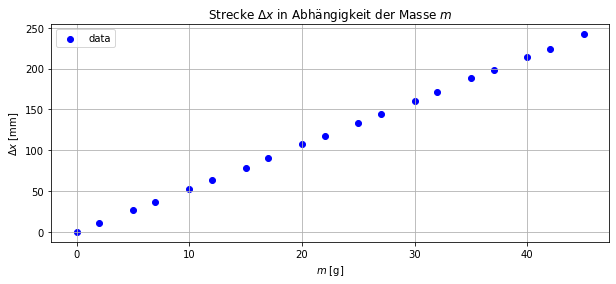

In [102]:
# Plot von Kalibrierungsdaten
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(m_cal, dx_cal, color='b', label='data')

ax.set(xlabel=r'$m$ [g]', ylabel=r'$\Delta x$ [mm]', title=r'Strecke $ \Delta x$ in Abhängigkeit der Masse $m$')
ax.legend()
ax.grid()

print("Parameter a: ", b)
print("Parameter b: ", m)

fig.savefig("auslenkung_masse.png")

0.06934679146053928
0.0004962585742822325
Parameter a:  0.12328689876772127
Parameter b:  0.18629652299531144


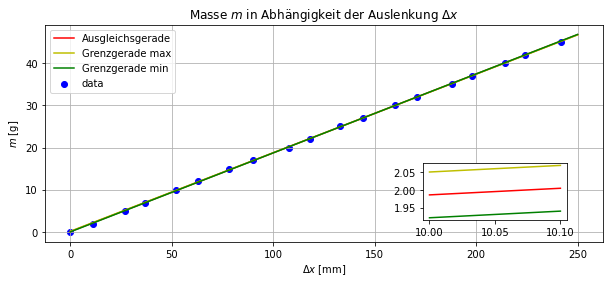

In [107]:
# Plot von lin Reg
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.scatter(dx_cal, m_cal, color='b', label='data')
m, b = np.polyfit(dx_cal, m_cal, 1)

x = np.linspace(0, 250, num = 200)

del_b = stuA(dx_cal, m_cal)
print(del_b)
del_m = stuB(dx_cal, m_cal)
print(del_m)

ax1.plot(x, x*m+b, color='r', label='Ausgleichsgerade')
ax1.plot(x, x*(m-del_m)+(b+del_b), color='y', label='Grenzgerade max')
ax1.plot(x, x*(m+del_m)+(b-del_b), color='g', label='Grenzgerade min')
#ax.errorbar(m_cal, dx_cal, xerr=0, yerr=, fmt='', color='b', label='Fehlerbalken')

x_det = np.linspace(10,10.1, num= 10)
y_det = x_det*m+b
y_det_max = x_det*(m-del_m)+(b+del_b)
y_det_min = x_det*(m+del_m)+(b-del_b)

# location for the zoomed portion 
sub_axes = plt.axes([.65, 0.2, .2, .2]) 

# plot the zoomed portion
sub_axes.plot(x_det, y_det_max, c = 'y') 
sub_axes.plot(x_det, y_det_min, c = 'g') 
sub_axes.plot(x_det, y_det, c = 'r')

ax1.set(xlabel=r'$\Delta x$ [mm]', ylabel=r'$m$ [g]', title=r'Masse $ m$ in Abhängigkeit der Auslenkung $\Delta x$')
ax1.legend()
ax1.grid()

print("Parameter a: ", b)
print("Parameter b: ", m)

fig.savefig("masse_auslenkung.png")

In [48]:
uns_z = np.array([0.38/(10**3), 132.96*(10**-9)])
werte_z = np.array([19.11/(10**3), 2650.77*(10**-9)])

uns_q = np.array([0.39/(10**3), vol_leg_f*vol_leg*(10**-9)])
werte_q = np.array([36.87/(10**3), vol_leg*(10**-9)])

exp = np.array([1, -1])

print(einfachGaussMult(uns_z, werte_z, exp))

print(einfachGaussMult(uns_q, werte_q, exp))

0.0539567851042925
0.0165162442878568


In [44]:
((44-242)*-0.1862)

36.8676

In [45]:
print((36.87*(10**-3))/(vol_leg*(10**-9)))

8240.468814954877
